In [7]:
library(readxl)

prb <- read_excel('../data/prb_10-9-2020.xlsx', sheet = 'K-PRB')

Warning message:
"Expecting numeric in D1059 / R1059C4: got 'na'"
New names:
• `Rb` -> `Rb...38`
• `Sr` -> `Sr...40`
• `Th` -> `Th...42`
• `U` -> `U...43`
• `Hf` -> `Hf...45`
• `Pb` -> `Pb...59`
• `Nd` -> `Nd...65`
• `Sm` -> `Sm...66`
• `Lu` -> `Lu...76`
• `Rb` -> `Rb...79`
• `Sr` -> `Sr...80`
• `Sm` -> `Sm...87`
• `Nd` -> `Nd...88`
• `Lu` -> `Lu...94`
• `Hf` -> `Hf...95`
• `U` -> `U...100`
• `Th` -> `Th...101`
• `Pb` -> `Pb...102`


In [69]:
library(tidyverse)

primaries <- select(prb,
    # Major Elements
    "SiO2",
    "TiO2", 
    "Al2O3", 
    # "FeO*", 
    "CaO", 
    "MgO", 
    "K2O", 
    "Na2O",
)

# Coerce fields with values like "> 0.10" to numeric "0.10"
numerical_data <- mutate_at(primaries, vars(-group_cols()), ~ as.numeric(stringr::str_replace_all(., "<", "")))

# numerical_data <- primaries %>% select_if(is.numeric) # Filter out non-numerical fields

# Filter out data with missing values
data <- numerical_data[complete.cases(numerical_data), ]
sprintf('Number of samples: %s', nrow(data))

[1] "Number of samples: 532"

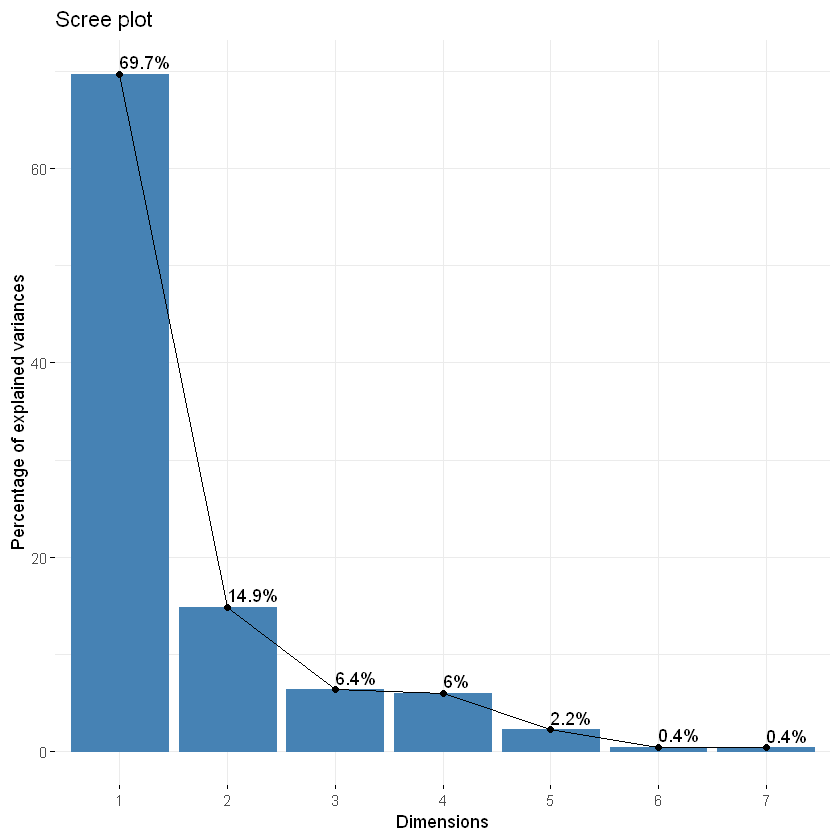

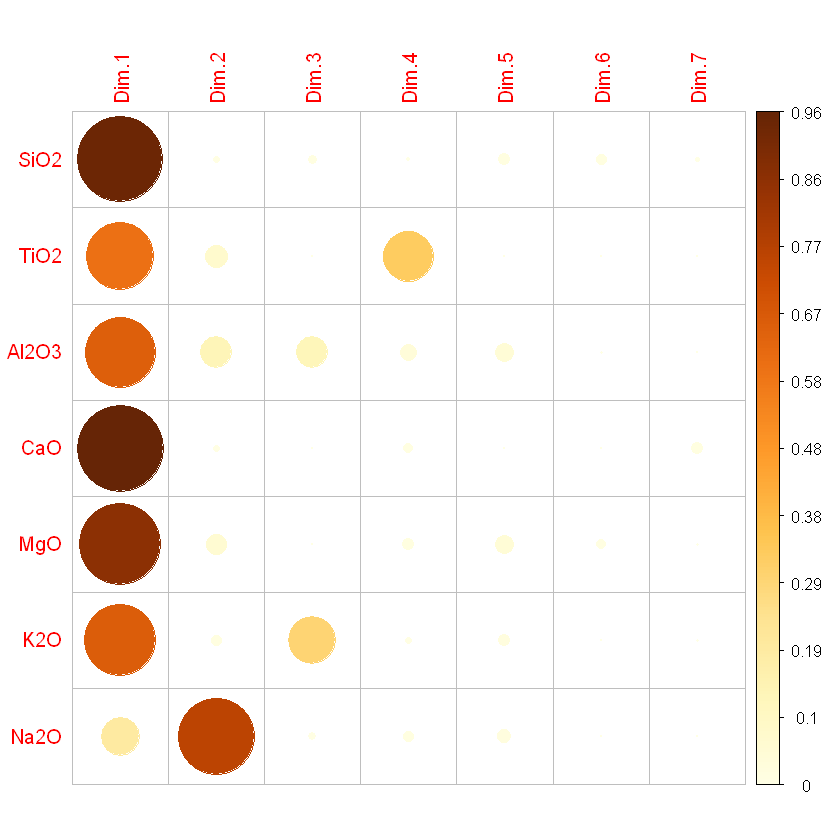

In [70]:
library(factoextra)
library(corrplot)

pca <- prcomp(data, scale = TRUE)
var <- get_pca_var(pca)
ind <- get_pca_ind(pca)

fviz_eig(pca, addlabels = TRUE)
corrplot(var$cos2, is.corr=FALSE)


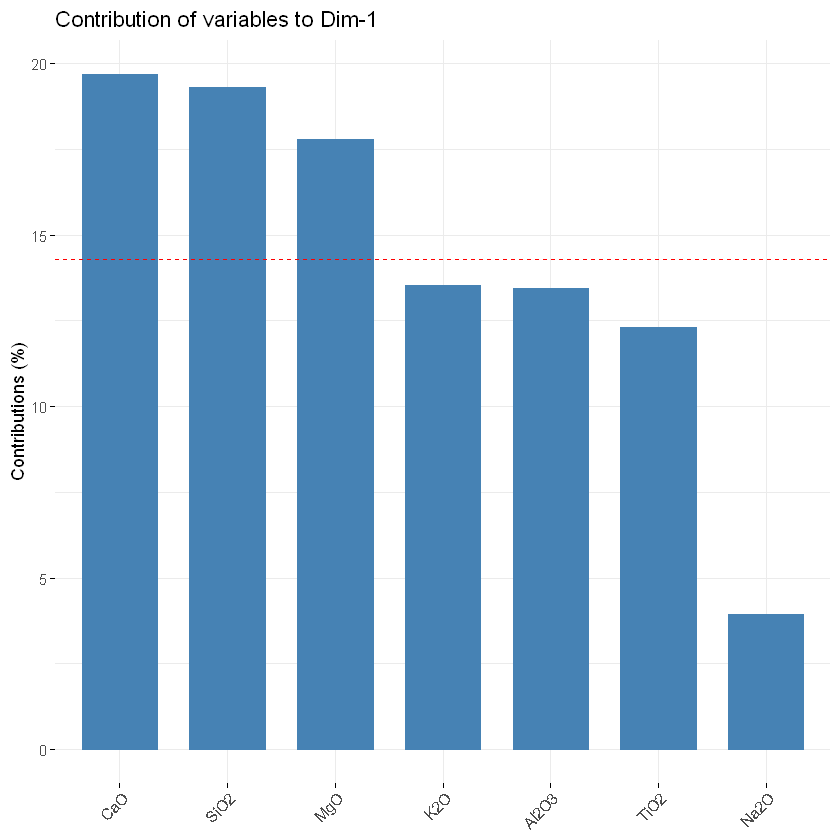

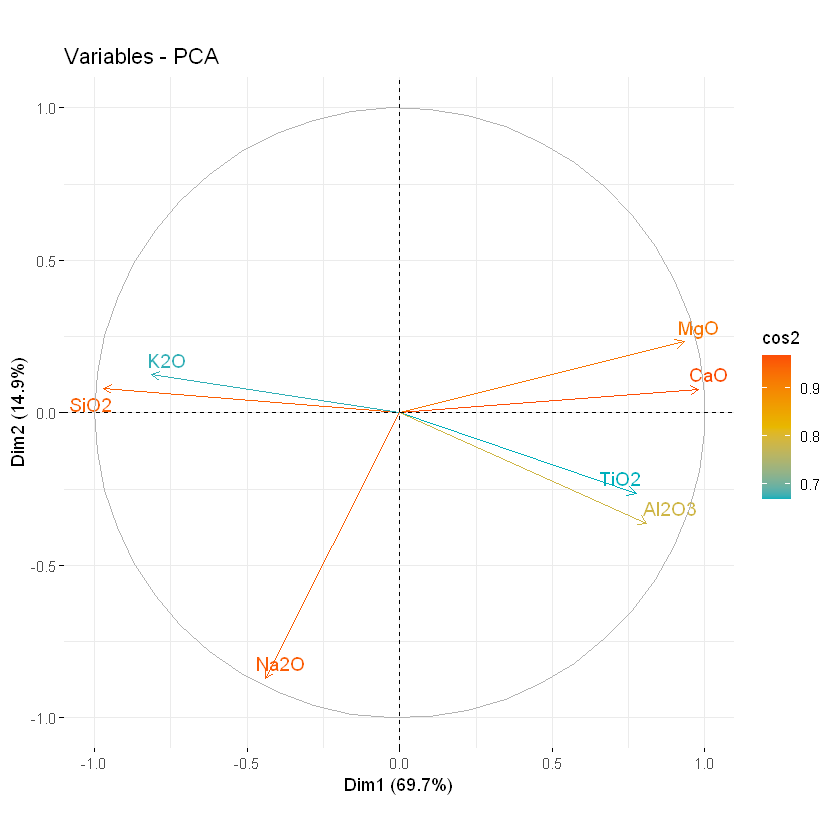

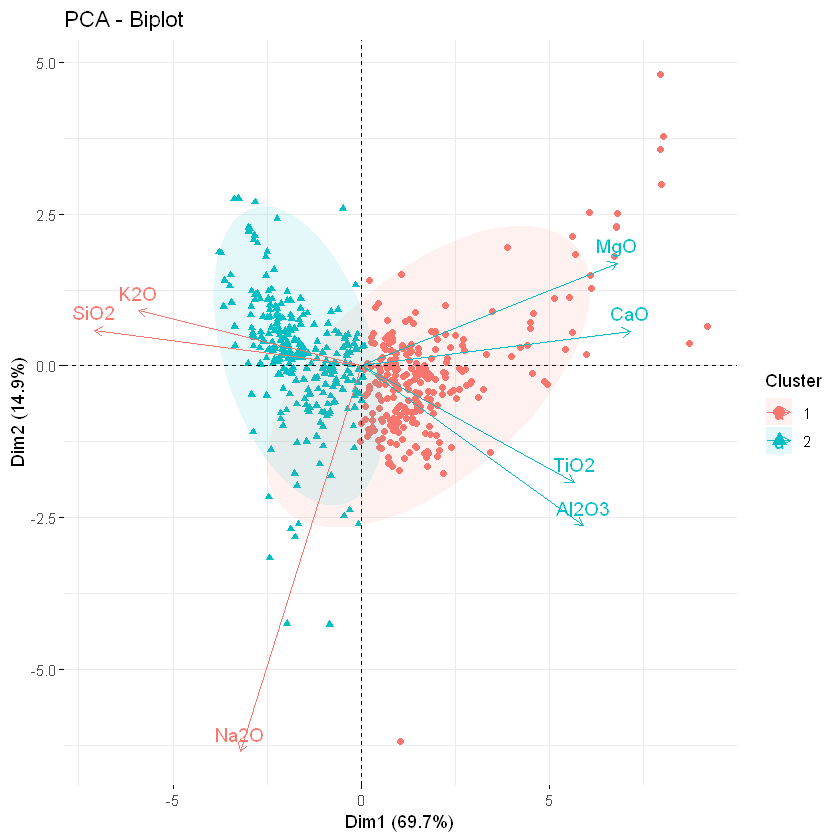

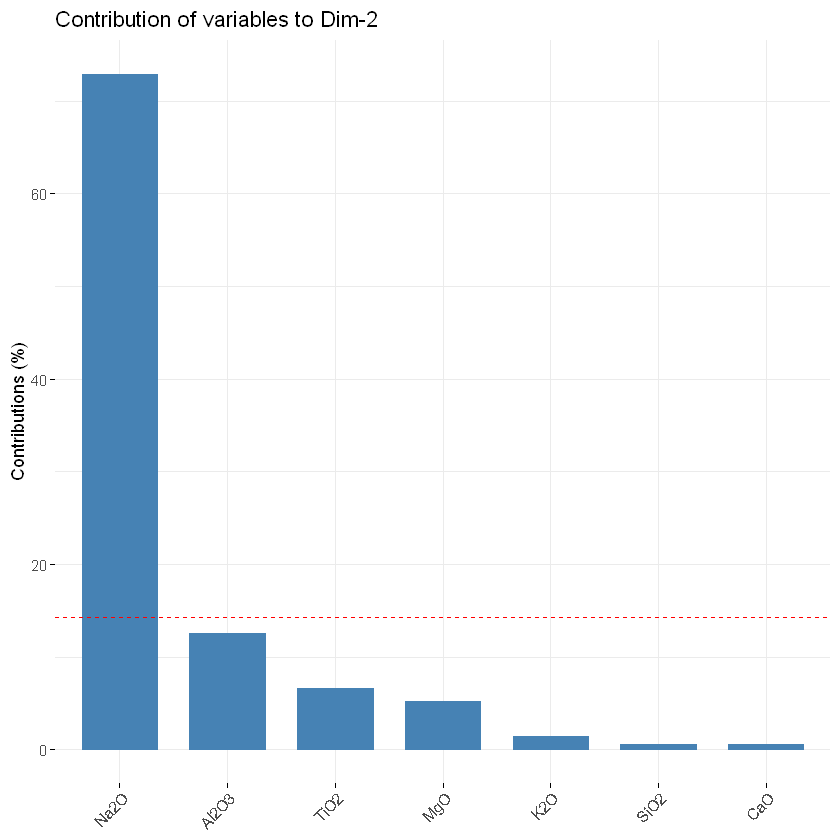

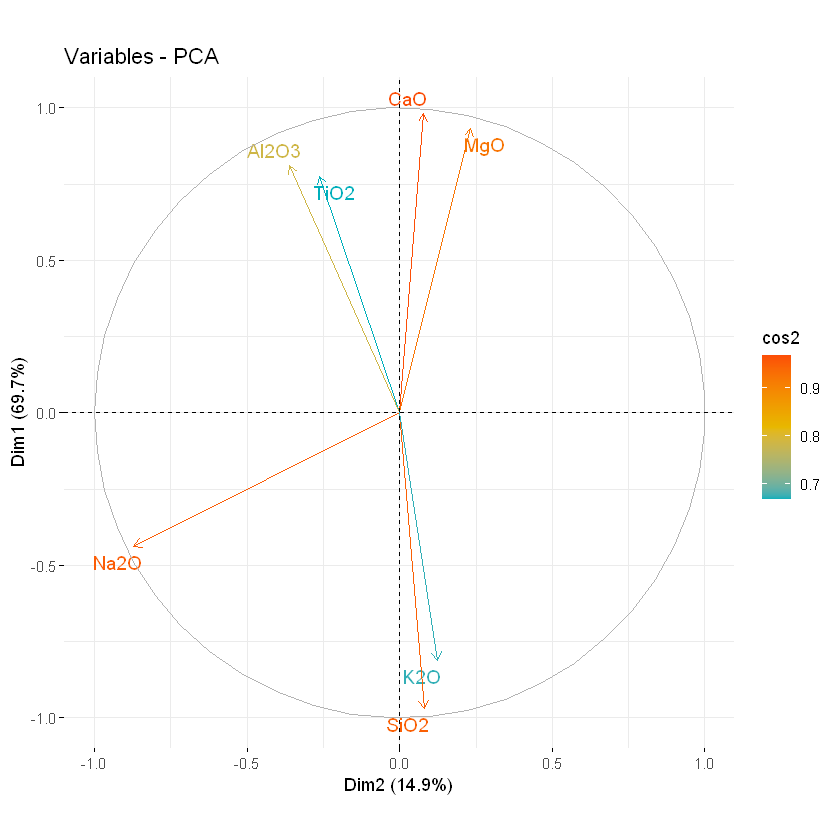

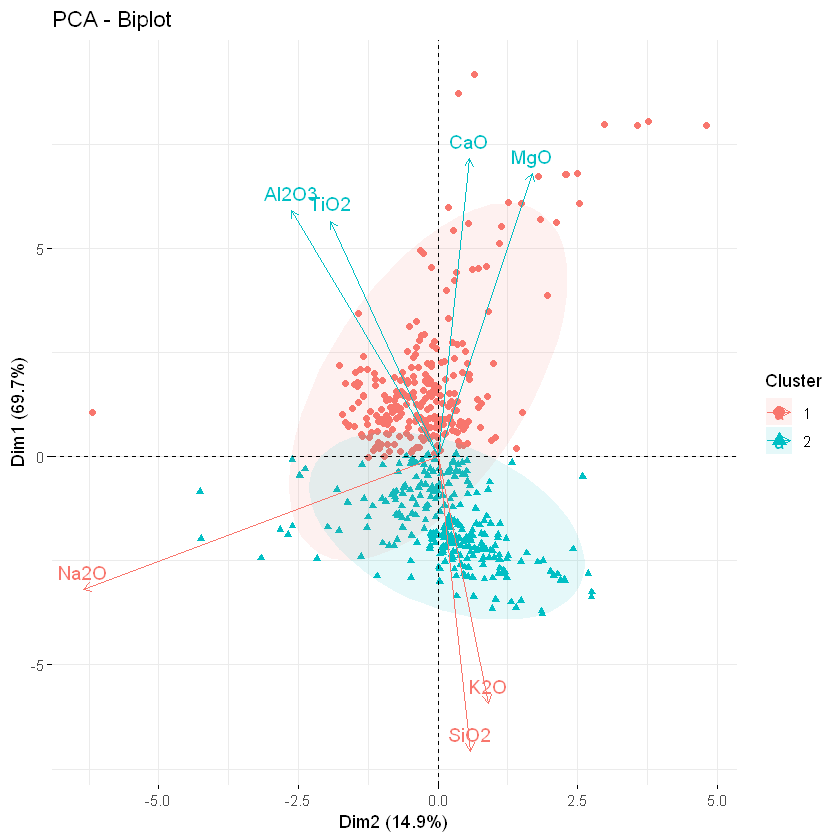

In [73]:
dim <- 2

set.seed(123)
km_var <- kmeans(var$coord, centers = dim, nstart = 25)
km_ind <- kmeans(ind$coord, centers = dim, nstart = 25)
km_var.grp <- as.factor(km_var$cluster)
km_ind.grp <- as.factor(km_ind$cluster)

for (i in 1:dim) {

  print(fviz_contrib(pca, choice = "var", axes = i, top = 10))

  for (k in 1:dim) {
    if (k == i) {
      next
    }
    print(fviz_pca_var(
      pca, 
      col.var = 'cos2', 
      gradient.cols = c('#00AFBB', '#E7B800', '#FC4E07'), 
      repel = TRUE,
      axes = c(i, k)
    ))

    print(fviz_pca(pca, 
      col.ind = km_ind.grp,
      col.var = km_var.grp,
      geom.ind = "point", 
      addEllipses = TRUE, 
      legend.title = "Cluster",
      axes = c(i, k)
    ))
  }
}

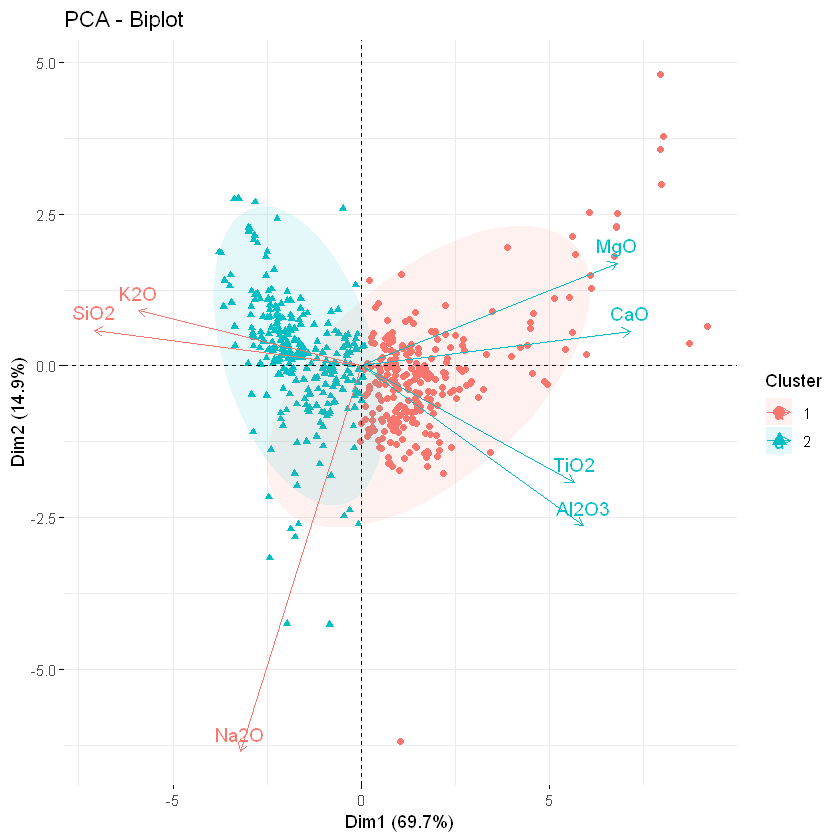

In [74]:
set.seed(123)
ind <- get_pca_ind(pca)
km_var <- kmeans(var$coord, centers = dim, nstart = 25)
km_ind <- kmeans(ind$coord, centers = dim, nstart = 25)
km_var.grp <- as.factor(km_var$cluster)
km_ind.grp <- as.factor(km_ind$cluster)

fviz_pca(pca, 
    col.ind = km_ind.grp,
    col.var = km_var.grp,
    geom.ind = "point", 
    addEllipses = TRUE, 
    legend.title = "Cluster",
)

# fviz_pca_var(
#     pca,
#     col.var = grp,
#     palette = c("#0073C2FF", "#EFC000FF", "#868686FF", "#9AD4D6", "#F2B8B8"),
#     legend.title = 'Cluster'
# )
# fviz_pca(
#     pca,
#     geom.ind = 'point',
#     col.var = grp,
#     col.ind = 'black',
#     palette = c("#0073C2FF", "#EFC000FF", "#868686FF", "#9AD4D6", "#F2B8B8"),
# )
# fviz_cluster(
#     km,
#     data = ind$coord,
#     geom = "point",
#     ellipse.type = "euclid",
# )